# Bagging alogorithm (using KNN as base estimator)

- performs best with algorithms that have __high variance.__

- fits base classifiers random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 

- Such a meta-estimator can typically be used as a way to reduce the variance of a __black-box estimator __ (e.g., a decision tree)

- How 
> by introducing randomization into its construction procedure and then making an ensemble out of it.



### parameters 

__base_estimator : __ 
The base estimator to fit on random subsets of the dataset. 
If None, then the base estimator is a decision tree.

__n_estimators :  int, optional (default=10)__
The number of base estimators in the ensemble.

__max_samples : int or float, optional (default=1.0)__
If int, then draw max_samples samples.
If float, then draw max_samples * X.shape[0] samples.
                
__max_features : int or float, optional (default=1.0) __
The number of features to draw from X to train each base estimator.
If int, then draw max_features features.
If float, then draw max_features * X.shape[1] features.
                
__bootstrap : boolean, optional (default=True)__
Whether samples are drawn with replacement.

__bootstrap_features : boolean, optional (default=False)__
Whether features are drawn with replacement.

__oob_score : bool, optional (default=False)__
Whether to use out-of-bag samples to estimate the generalization error.


In [6]:
# Bagged Decision Trees for Classification
import pandas as pd
import numpy as np
from sklearn import model_selection

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import adjusted_rand_score

C:\Software\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


### parameters 

__base_estimator : __ 
The base estimator to fit on random subsets of the dataset. 
If None, then the base estimator is a decision tree.

__n_estimators :  int, optional (default=10)__
The number of base estimators in the ensemble.

__max_samples : int or float, optional (default=1.0)__
If int, then draw max_samples samples.
If float, then draw max_samples * X.shape[0] samples.
                
__max_features : int or float, optional (default=1.0) __
The number of features to draw from X to train each base estimator.
If int, then draw max_features features.
If float, then draw max_features * X.shape[1] features.
                
__bootstrap : boolean, optional (default=True)__
Whether samples are drawn with replacement.

__bootstrap_features : boolean, optional (default=False)__
Whether features are drawn with replacement.

__oob_score : bool, optional (default=False)__
Whether to use out-of-bag samples to estimate the generalization error.


In [3]:
from pydataset import data

initiated datasets repo at: C:\Users\santa_000\.pydataset/


In [4]:
# Get the housing data
df = data('Housing')
df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [4]:
# Create dictionary to label 'yes' and 'no'
d = dict(zip(['no', 'yes'], range(0,2)))

for i in zip(df.dtypes.index, df.dtypes):
    if str(i[1]) == 'object':
        df[i[0]] = df[i[0]].map(d)

#### Pandas qcut

In [7]:
pd.qcut(range(1, 10, 1), 2)

[(0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (5.0, 9.0], (5.0, 9.0], (5.0, 9.0], (5.0, 9.0]]
Categories (2, interval[float64]): [(0.999, 5.0] < (5.0, 9.0]]

In [8]:
pd.qcut(range(1, 10, 1), 3, labels=["good", "medium", "bad"])

[good, good, good, medium, medium, medium, bad, bad, bad]
Categories (3, object): [good < medium < bad]

.. back to the main code ..

In [9]:
# Before we bucket our prices, let’s look at the ranges of our prices.

# Looks like the lowest house we have in the dataset is $25K, and 
# the highest is $190K. 
for i, j in enumerate(np.unique(pd.qcut(df['price'], 3))):
    print(i, j)

0 (24999.999, 53000.0]
1 (53000.0, 74500.0]
2 (74500.0, 190000.0]


In [10]:
df['price'] = pd.qcut(df['price'], 3, labels=['0', '1', '2']).cat.codes

# Split into two sets
X = df.drop('price', 1)
y = df['price'] 

In [11]:
df.shape

(546, 12)

In [29]:
df.head()
df_dumm =pd.get_dummies(df,columns=['driveway','recroom','fullbase','gashw','airco','prefarea'])
df1=df.merge(df_dumm)
df1=df1.drop(columns=['driveway','recroom','fullbase','gashw','airco','prefarea'],axis=1)
X = df1.drop('price', 1)
y = df1['price']

In [30]:
# For testing, we choose to split our data to 75% train and 25% for test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [31]:
# instantiate a knn
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [32]:
# instantiate the bagging classifier
seed = 7

num_trees = 100

baggclf = BaggingClassifier(base_estimator=knn, 
                          n_estimators=num_trees, 
                          oob_score=True, 
                          max_samples=0.5, 
                          max_features=0.5,
                          random_state=seed)

In [33]:
# results = cross_val_score(baggclf, X, y, cv=kfold)

# print(results)
# print(results.mean())

In [34]:
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

scores = cross_validate(baggclf, 
                        X, 
                        y, 
                        cv=5, 
                        scoring=scoring, 
                        return_train_score=True 
                        #return_estimator=True
                       )

#print(scores.keys())
print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))


  Training accuracy :  [0.93203883 0.93398058 0.93592233 0.93009709 0.93604651]  mean :  0.93
  testing  accuracy :  [0.56589147 0.60465116 0.62015504 0.65891473 0.625     ]  mean :  0.61


In [35]:
for key in scores:
    print(key, scores[key], scores[key].mean() )

fit_time [0.30223155 0.29519224 0.28920817 0.32923412 0.38027   ] 0.3192272186279297
score_time [0.08804512 0.09107709 0.09404874 0.09006357 0.09206676] 0.09106025695800782
test_accuracy [0.56589147 0.60465116 0.62015504 0.65891473 0.625     ] 0.614922480620155
train_accuracy [0.93203883 0.93398058 0.93592233 0.93009709 0.93604651] 0.9336170693158726
test_f1_macro [0.55013299 0.55906433 0.58691685 0.61098784 0.58293552] 0.5780075058828664
train_f1_macro [0.93035427 0.93069894 0.93415683 0.92665601 0.93422323] 0.931217856478623
test_precision_macro [0.5489418  0.59011164 0.58510826 0.61033656 0.60641912] 0.5881834760065054
train_precision_macro [0.93644823 0.93914041 0.93755659 0.93644959 0.94403845] 0.9387266547813689
test_recall_macro [0.55167681 0.5764411  0.59855394 0.63510734 0.61450501] 0.5952568419717397
train_recall_macro [0.92711916 0.92728004 0.93207762 0.92322757 0.92979859] 0.9279005958222729


A case of __overfitted__ model, can we try a few other base models

In [36]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=4000, random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier()

In [37]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                                n_estimators=num_trees, 
                                oob_score=True, 
                                max_samples=0.5, 
                                max_features='log2',
                                random_state=seed)
    
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.70873786 0.76893204 0.72621359 0.75145631 0.76550388]  mean :  0.74
  testing  accuracy :  [0.72093023 0.60465116 0.73643411 0.72093023 0.65625   ]  mean :  0.69
Estimator :  Random Forest
  Training accuracy :  [0.9961165  0.99417476 0.99805825 0.9961165  0.99612403]  mean :  1.0
  testing  accuracy :  [0.59689922 0.65116279 0.66666667 0.73643411 0.6796875 ]  mean :  0.67
Estimator :  Naive Bayes
  Training accuracy :  [0.6815534  0.71650485 0.69514563 0.69126214 0.70930233]  mean :  0.7
  testing  accuracy :  [0.72093023 0.62790698 0.65891473 0.69767442 0.5546875 ]  mean :  0.65
Estimator :  Decision Tree
  Training accuracy :  [0.9961165  0.9961165  0.99805825 0.9961165  0.99612403]  mean :  1.0
  testing  accuracy :  [0.59689922 0.52713178 0.58914729 0.64341085 0.578125  ]  mean :  0.59


Both RF and DT show similar case of overfitting and LogReg and NB show the case of underfitted model

#### Can we try scaling the data ?

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [39]:
rescaledX = scaler.fit_transform(X)


In [40]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                              n_estimators=num_trees, 
                              oob_score=True, 
                              max_samples=0.5, 
                              max_features=0.5,
                              random_state=seed)
    
    scores = cross_validate(baggclf, rescaledX, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.68543689 0.71262136 0.68349515 0.69514563 0.71124031]  mean :  0.7
  testing  accuracy :  [0.68217054 0.62790698 0.68217054 0.65891473 0.59375   ]  mean :  0.65
Estimator :  Random Forest
  Training accuracy :  [0.88737864 0.8815534  0.88932039 0.87378641 0.88565891]  mean :  0.88
  testing  accuracy :  [0.6744186  0.62015504 0.73643411 0.71317829 0.6328125 ]  mean :  0.68
Estimator :  Naive Bayes
  Training accuracy :  [0.63300971 0.56893204 0.67961165 0.65631068 0.67829457]  mean :  0.64
  testing  accuracy :  [0.58914729 0.58139535 0.68992248 0.66666667 0.5390625 ]  mean :  0.61
Estimator :  Decision Tree
  Training accuracy :  [0.92815534 0.93009709 0.93592233 0.9223301  0.93217054]  mean :  0.93
  testing  accuracy :  [0.65116279 0.65891473 0.69767442 0.72868217 0.6640625 ]  mean :  0.68


#### Try the following:-
- bootstrap=True          --> for the samples to be drawn with replacement
- bootstrap_features=True --> for the features to be drawn with replacement
- max_features={try 'sqrt', 'log2'}


In [41]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                                n_estimators=num_trees, 
                                bootstrap=True, 
                                bootstrap_features=True,
                                oob_score=True, 
                                #max_samples=0.5, 
                                max_features='log2',
                                random_state=seed)
    
    scores = cross_validate(clf, rescaledX, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.72621359 0.75728155 0.72427184 0.73592233 0.73255814]  mean :  0.74
  testing  accuracy :  [0.72868217 0.6124031  0.70542636 0.71317829 0.65625   ]  mean :  0.68
Estimator :  Random Forest
  Training accuracy :  [0.9961165  0.99417476 0.99805825 0.9961165  0.99612403]  mean :  1.0
  testing  accuracy :  [0.60465116 0.65116279 0.6744186  0.73643411 0.6796875 ]  mean :  0.67
Estimator :  Naive Bayes
  Training accuracy :  [0.6776699  0.70291262 0.69514563 0.6815534  0.71124031]  mean :  0.69
  testing  accuracy :  [0.68217054 0.63565891 0.65891473 0.69767442 0.546875  ]  mean :  0.64
Estimator :  Decision Tree
  Training accuracy :  [0.9961165  0.9961165  0.99805825 0.9961165  0.99612403]  mean :  1.0
  testing  accuracy :  [0.57364341 0.53488372 0.59689922 0.63565891 0.6171875 ]  mean :  0.59


#### look at the OOB score

In [42]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

baggclf = BaggingClassifier(base_estimator=rf, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

# compare OOB accuracy to test-set accuracy
acc_oob = baggclf.oob_score_
print(acc_oob)                  

# clf4 = DecisionTreeClassifier()

0.7329192546583851


OOB score also indicates there is overfitting

In [22]:
dt = DecisionTreeClassifier(random_state=1)

baggclf = BaggingClassifier(base_estimator=dt, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

# compare OOB accuracy to test-set accuracy
acc_oob = baggclf.oob_score_
print(acc_oob)               

0.673992673992674


OOB score also indicates there is overfitting, still , with decision tree too!!!

# Getting feature importances

In [43]:
dt = DecisionTreeClassifier(random_state=1)

baggclf = BaggingClassifier(base_estimator=dt, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            #max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

feature_importances = np.mean([ tree.feature_importances_ for tree in baggclf.estimators_ ], axis=0)
feature_importances

array([0.06095243, 0.05632617, 0.06115493, 0.05203443, 0.04313746,
       0.0579601 , 0.05837465, 0.04973053, 0.05254608, 0.08688901,
       0.04973739, 0.04767126, 0.07120303, 0.07804735, 0.06110035,
       0.06921694, 0.04391789])

In [44]:
X.columns

Index(['lotsize', 'bedrooms', 'bathrms', 'stories', 'garagepl', 'driveway_no',
       'driveway_yes', 'recroom_no', 'recroom_yes', 'fullbase_no',
       'fullbase_yes', 'gashw_no', 'gashw_yes', 'airco_no', 'airco_yes',
       'prefarea_no', 'prefarea_yes'],
      dtype='object')

In [45]:
# feature Importance
# Get numerical feature importances
importances = list(feature_importances)
importances

[0.06095242796662398,
 0.05632617483887712,
 0.06115492785437457,
 0.05203443277963138,
 0.04313745893981468,
 0.05796010159142915,
 0.05837464521451886,
 0.04973052856593042,
 0.05254608297062431,
 0.08688900996517264,
 0.04973739009341571,
 0.04767125941750718,
 0.07120303361036366,
 0.0780473453844616,
 0.06110034542938408,
 0.06921694414722906,
 0.0439178912306415]

In [46]:
# List of tuples with feature and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances

[('lotsize', 0.06),
 ('bedrooms', 0.06),
 ('bathrms', 0.06),
 ('stories', 0.05),
 ('garagepl', 0.04),
 ('driveway_no', 0.06),
 ('driveway_yes', 0.06),
 ('recroom_no', 0.05),
 ('recroom_yes', 0.05),
 ('fullbase_no', 0.09),
 ('fullbase_yes', 0.05),
 ('gashw_no', 0.05),
 ('gashw_yes', 0.07),
 ('airco_no', 0.08),
 ('airco_yes', 0.06),
 ('prefarea_no', 0.07),
 ('prefarea_yes', 0.04)]

In [47]:
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('fullbase_no', 0.09),
 ('airco_no', 0.08),
 ('gashw_yes', 0.07),
 ('prefarea_no', 0.07),
 ('lotsize', 0.06),
 ('bedrooms', 0.06),
 ('bathrms', 0.06),
 ('driveway_no', 0.06),
 ('driveway_yes', 0.06),
 ('airco_yes', 0.06),
 ('stories', 0.05),
 ('recroom_no', 0.05),
 ('recroom_yes', 0.05),
 ('fullbase_yes', 0.05),
 ('gashw_no', 0.05),
 ('garagepl', 0.04),
 ('prefarea_yes', 0.04)]

# check if multi collinearity exists

In [48]:
import scipy 
import scipy.linalg as la

In [49]:
# check the multi collinearity
corr = scipy.corrcoef(rescaledX, rowvar=False)

eigvals, eigvecs = la.eig(corr)

eigvals = eigvals.real

print(eigvals)
print(eigvecs)

C:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: scipy.corrcoef is deprecated and will be removed in SciPy 2.0.0, use numpy.corrcoef instead
  


[ 3.67291282e+00  2.52603135e+00  2.08761109e+00  2.03872928e+00
  4.14364205e-01  5.70316357e-01  6.09899446e-01  1.58886896e+00
  1.03474890e+00  1.19835861e+00  1.25815898e+00  2.42239953e-16
 -1.92053529e-16 -1.92053529e-16  2.76206109e-17 -9.46211927e-17
 -2.19437976e-17]
[[ 2.68581215e-01+0.00000000e+00j -1.25057715e-01+0.00000000e+00j
   4.65292378e-02+0.00000000e+00j -1.39236971e-01+0.00000000e+00j
   1.90031855e-01+0.00000000e+00j  5.47215726e-01+0.00000000e+00j
   5.11955285e-01+0.00000000e+00j -1.69206165e-02+0.00000000e+00j
  -5.26688686e-01+0.00000000e+00j -1.21123353e-01+0.00000000e+00j
   2.56764238e-02+0.00000000e+00j -4.12723350e-18+0.00000000e+00j
  -5.88111810e-18+4.43323151e-17j -5.88111810e-18-4.43323151e-17j
  -9.55023390e-18+0.00000000e+00j  4.55716434e-17+0.00000000e+00j
   3.10907143e-17+0.00000000e+00j]
 [ 2.11576913e-01+0.00000000e+00j -1.33964600e-01+0.00000000e+00j
   2.43832375e-01+0.00000000e+00j  1.33578011e-01+0.00000000e+00j
  -5.43575866e-01+0.0000000

there seems to __no multi-collinearity__, as there no eigen value = 0

In [50]:
new_X = pd.DataFrame(data=rescaledX, columns=X.columns)

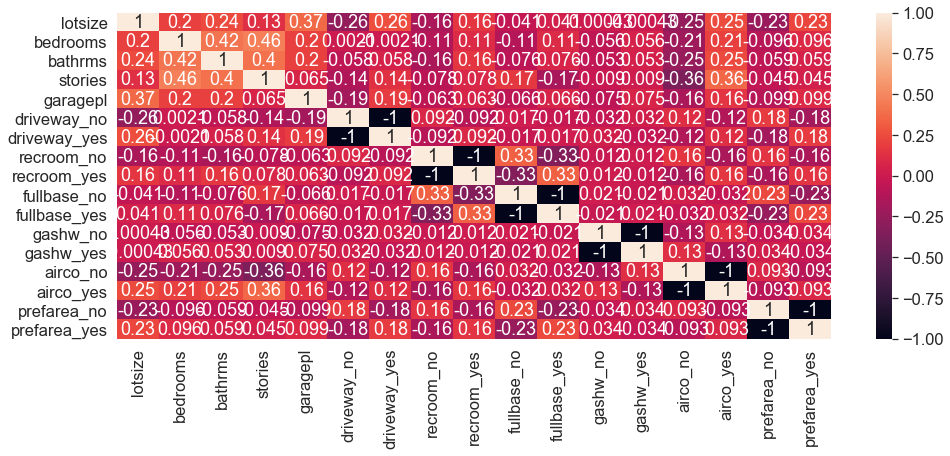

In [51]:
plt.figure(figsize=(16, 6))
sns.heatmap(new_X.corr(), annot=True);

no strong correlation between the independent variables, as well.



# let us check VIF for multi-collinearity

VIF values of 10 or greater indicate __Multicolinearity__

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy as sp

In [53]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["feature"] = X.columns

vif.sort_values(['VIF_Factor'], ascending=False).round(5)

C:\Software\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,feature
8,inf,recroom_yes
9,inf,fullbase_no
15,inf,prefarea_no
14,inf,airco_yes
13,inf,airco_no
12,inf,gashw_yes
11,inf,gashw_no
10,inf,fullbase_yes
16,inf,prefarea_yes
7,inf,recroom_no


** observation **

there is some indication of multi-collinearity with columns
- bedrooms
- bathrms

But not too bad, it appears

# But why the overfitting???

In [54]:
new_X.head()

,lotsize,bedrooms,bathrms,stories,garagepl,driveway_no,driveway_yes,recroom_no,recroom_yes,fullbase_no,fullbase_yes,gashw_no,gashw_yes,airco_no,airco_yes,prefarea_no,prefarea_yes
0,0.288660,0.4,0.0,0.333333,0.333333,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.161512,0.2,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.161512,0.2,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.161512,0.2,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.161512,0.2,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# let us try learning curve

In [55]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=4000, random_state=1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier()

In [56]:
# instantiate the bagging classifier
num_trees = 10

baggclf = BaggingClassifier(base_estimator=clf2, 
                          n_estimators=num_trees, 
                          random_state=1)

In [57]:
scoring = ['accuracy']

scores = cross_validate(baggclf, 
                        rescaledX, 
                        y, 
                        cv=5, 
                        scoring=scoring, 
                        return_train_score=True
                        )

#print(scores.keys())
print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

  Training accuracy :  [0.95533981 0.94951456 0.96893204 0.9631068  0.96124031]  mean :  0.96
  testing  accuracy :  [0.65116279 0.6124031  0.72093023 0.75968992 0.6796875 ]  mean :  0.68


In [58]:
# execute the learning curve
train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator=baggclf,
                                                         X=rescaledX,
                                                         y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=10
                                                         )

In [59]:
train_sizes

array([ 57, 115, 173, 231, 289, 347, 405, 463, 521, 579])

In [60]:
test_scores

array([[0.4       , 0.84615385, 0.38461538, 0.44615385, 0.359375  ,
        0.421875  , 0.40625   , 0.40625   , 0.375     , 0.453125  ],
       [0.52307692, 0.8       , 0.46153846, 0.47692308, 0.46875   ,
        0.59375   , 0.515625  , 0.46875   , 0.453125  , 0.65625   ],
       [0.49230769, 0.81538462, 0.52307692, 0.53846154, 0.59375   ,
        0.59375   , 0.59375   , 0.609375  , 0.625     , 0.71875   ],
       [0.52307692, 0.81538462, 0.58461538, 0.52307692, 0.6875    ,
        0.609375  , 0.609375  , 0.671875  , 0.671875  , 0.703125  ],
       [0.55384615, 0.84615385, 0.6       , 0.52307692, 0.578125  ,
        0.609375  , 0.609375  , 0.65625   , 0.65625   , 0.671875  ],
       [0.53846154, 0.83076923, 0.66153846, 0.55384615, 0.515625  ,
        0.625     , 0.6875    , 0.65625   , 0.65625   , 0.578125  ],
       [0.55384615, 0.78461538, 0.67692308, 0.61538462, 0.59375   ,
        0.78125   , 0.8125    , 0.671875  , 0.734375  , 0.640625  ],
       [0.49230769, 0.76923077, 0.6461538

In [43]:
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)

test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores,  axis=1)

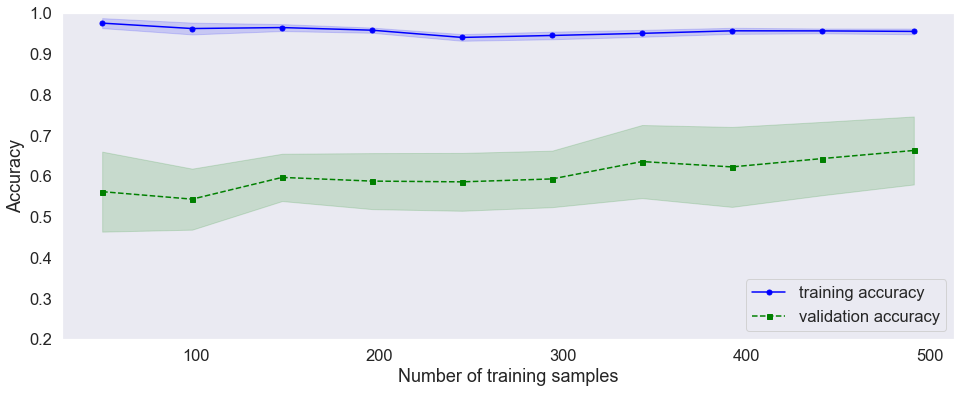

In [44]:
plt.figure(figsize=(16, 6))

plt.plot(train_sizes, 
         train_mean,
         color='blue', 
         marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
         train_mean + train_std,
         train_mean - train_std,
         alpha=0.15, 
         color='blue')  

plt.plot(train_sizes, 
         test_mean,
         color='green', 
         linestyle='--',
         marker='s', 
         markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.2, 1.0]);

# Still not improved, Increase sample size, may be!

# PCA

In [165]:
from itertools import combinations
from itertools import combinations_with_replacement 
from itertools import permutations 

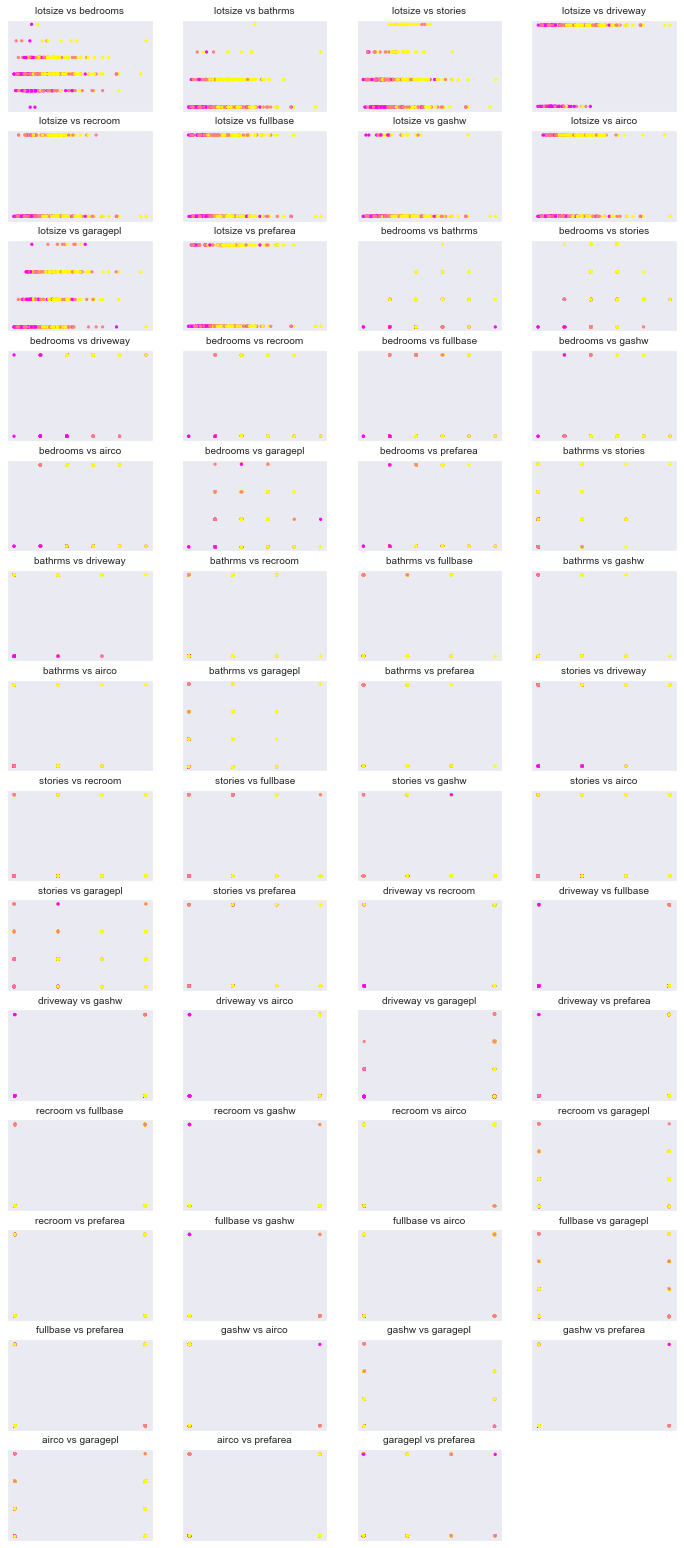

In [166]:
plt.figure(figsize=(12,30))

i = 1
for col_c in list(combinations(X.columns, 2)):
    
    col1 = col_c[0]
    col2 = col_c[1]
    
    plt.subplot(15, 4, i)
    plt.title(col1+' vs '+col2, fontsize=10)
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(X[col1], 
                X[col2],
                c=y,
                cmap='spring',
                s=5
    );
    i = i +1

In [167]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

In [168]:
pc = pca.fit_transform(rescaledX)

In [169]:
# make a pandas data frame with the principal components (PCs) and 
# the known cluster assignments.

pc_df = pd.DataFrame(data = pc , 
                     columns = ['PC1', 'PC2','PC3','PC4'])

pc_df['Cluster'] = y

print(pc_df.shape)

print("Explained Variance: ", pca.explained_variance_ratio_)

(546, 5)
Explained Variance:  [0.26594813 0.19949716 0.13727251 0.09902298]


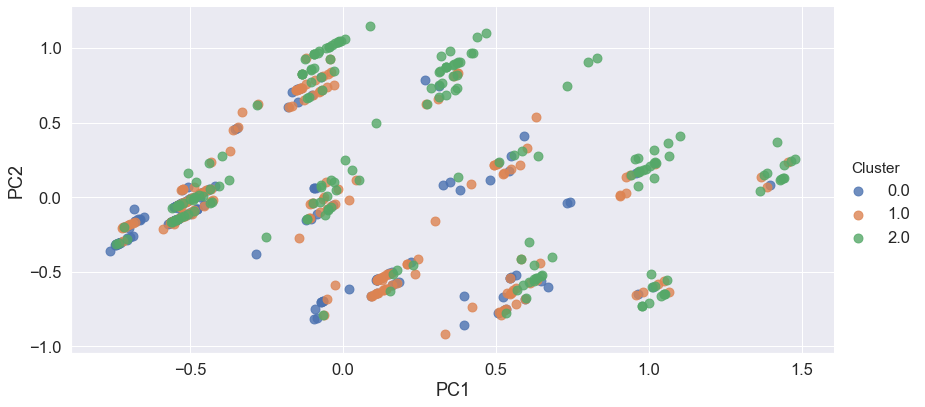

In [170]:
sns.lmplot(x="PC1", 
           y="PC2",
           data=pc_df, 
           fit_reg=False, 
           hue='Cluster', # color by cluster
           legend=True,
           scatter_kws={"s": 80},
           height=6,
           aspect=2);

<IPython.core.display.Javascript object>


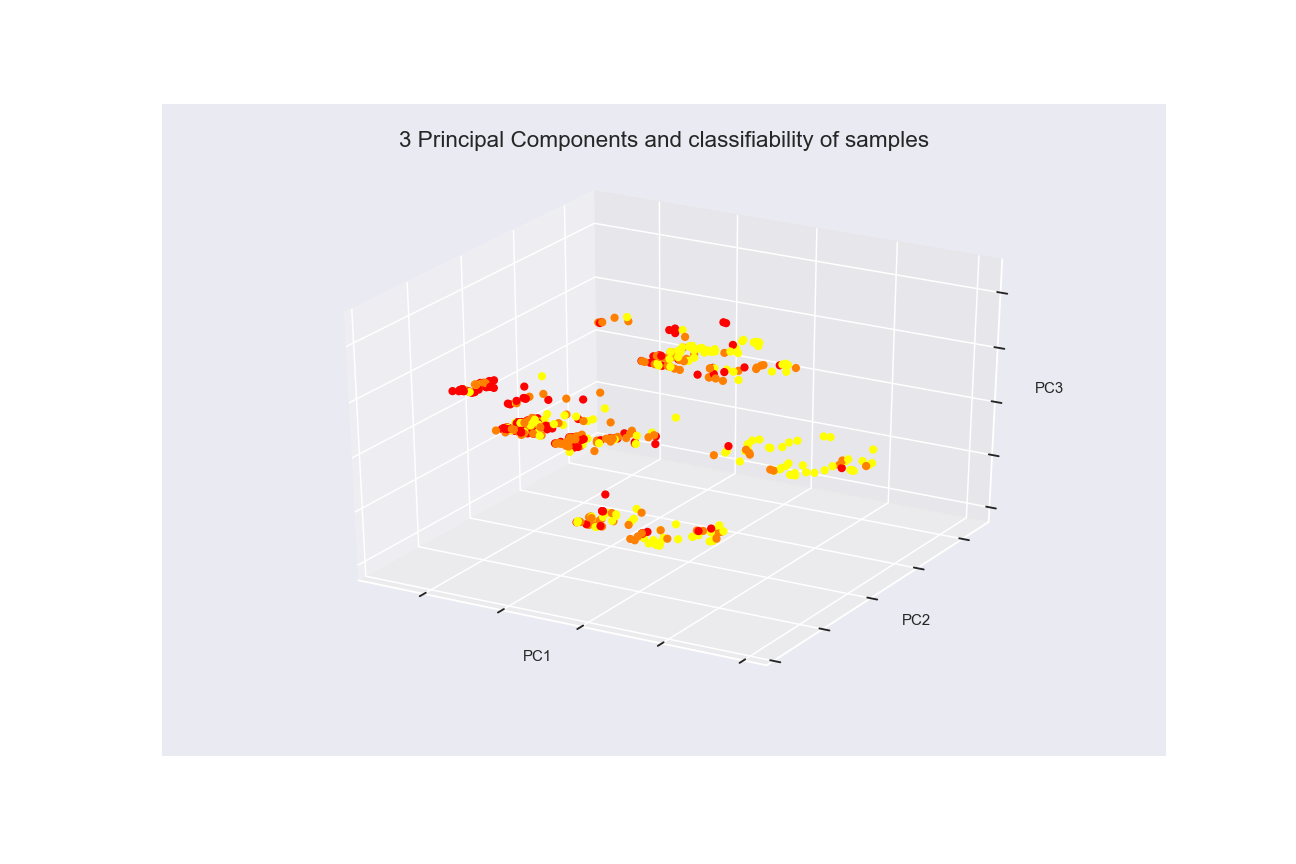

In [171]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( pc_df['PC1'],
            pc_df['PC2'],
            pc_df['PC3'],
            c=pc_df['Cluster'], 
            marker='o', 
            alpha=1,
            cmap='autumn')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_zlabel('PC3', fontsize=10)

ax.set_title('3 Principal Components and classifiability of samples', fontsize=15)

ax.dist = 12